## H10: Einfluss des Linientyps auf die Ankunftsverspätung

**Fragestellung:**  
Unterscheiden sich die Verspätungsverteilungen zwischen Fernverkehrszügen (IC/IR/EC/EN), Regionalzügen (RE/R) und S-Bahnen?

**Ziel:**  
Wir möchten statistisch prüfen, ob der Linientyp einen Einfluss auf die Ankunftsverspätung hat.

**Variable:**  
- Ankunftsverspätung in Minuten: `arr_delay_min = delay_arrival_s / 60`

**Gruppen:**
- Fernverkehr (IC, IR, EC, EN)
- Regional (RE, R)
- S-Bahn (S...)

Wir orientieren uns an den Schritten aus den Vorlesungen **VL7–VL9**:
1. Hypothesen spezifizieren
2. Deskriptive Auswertung & Visualisierung
3. Testwahl begründen
4. Test durchführen (Kruskal–Wallis)
5. Interpretation

In [20]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kruskal, mannwhitneyu
# WICHTIG: Pfad auf die Datei mit PRODUKT_ID und LINIEN_TEXT setzen
# Falls dein Pfad anders ist, hier anpassen:
path_h10 = "../data/processed/istdata_real_2025-09.parquet"

lf_h10 = pl.scan_parquet(path_h10)

print("Schema H10:")
print(lf_h10.schema)

Schema H10:
Schema({'BETRIEBSTAG': String, 'BETREIBER_NAME': String, 'PRODUKT_ID': Categorical, 'LINIEN_TEXT': String, 'HALTESTELLEN_NAME': String, 'ANKUNFTSZEIT': Datetime(time_unit='ns', time_zone='UTC'), 'ABFAHRTSZEIT': Datetime(time_unit='ns', time_zone='UTC'), 'delay_arrival_s': Float64, 'delay_departure_s': Float64, 'on_time': Boolean, 'FAELLT_AUS_TF': Boolean, 'BPUIC': String})


/tmp/ipykernel_72072/772511472.py:12: PerformanceWarning: Resolving the schema of a LazyFrame is a potentially expensive operation. Use `LazyFrame.collect_schema()` to get the schema without this warning.
  print(lf_h10.schema)


In [21]:
# Nur Züge + relevante Spalten + Verspätung in Minuten (LAZY)
lf_trains = (
    lf_h10
    .filter(pl.col("PRODUKT_ID") == "Zug")
    .select([
        "BETRIEBSTAG",
        "LINIEN_TEXT",
        "HALTESTELLEN_NAME",
        "delay_arrival_s",
        "delay_departure_s",
    ])
    .with_columns([
        (pl.col("delay_arrival_s") / 60).alias("arr_delay_min"),
        (pl.col("delay_departure_s") / 60).alias("dep_delay_min"),
    ])
    .filter(pl.col("arr_delay_min").is_not_null())
    .filter(
        (pl.col("arr_delay_min") >= -60) &
        (pl.col("arr_delay_min") <= 60)
    )
)

# Kleine Vorschau: 5 Zeilen materialisieren
df_trains_head = lf_trains.head(5).collect()
df_trains_head

BETRIEBSTAG,LINIEN_TEXT,HALTESTELLEN_NAME,delay_arrival_s,delay_departure_s,arr_delay_min,dep_delay_min
str,str,str,f64,f64,f64,f64
"""01.09.2025""","""IR3""","""Schaffhausen""",114.0,78.0,1.9,1.3
"""01.09.2025""","""RE3""","""Schaffhausen""",42.0,1.0,0.7,0.016667
"""01.09.2025""","""IR3""","""Schaffhausen""",31.0,17.0,0.516667,0.283333
"""01.09.2025""","""RE3""","""Schaffhausen""",18.0,-2.0,0.3,-0.033333
"""01.09.2025""","""IR3""","""Schaffhausen""",83.0,20.0,1.383333,0.333333


In [22]:
# Zelle 3: Linientypen aus LINIEN_TEXT ableiten (LAZY, mit pl.lit)

lf_linien = (
    lf_trains
    .with_columns(
        pl.when(pl.col("LINIEN_TEXT").str.starts_with("IC"))
          .then(pl.lit("Fernverkehr"))
        .when(pl.col("LINIEN_TEXT").str.starts_with("IR"))
          .then(pl.lit("Fernverkehr"))
        .when(pl.col("LINIEN_TEXT").str.starts_with("EC"))
          .then(pl.lit("Fernverkehr"))
        .when(pl.col("LINIEN_TEXT").str.starts_with("EN"))
          .then(pl.lit("Fernverkehr"))
        .when(pl.col("LINIEN_TEXT").str.starts_with("RE"))
          .then(pl.lit("Regional"))
        .when(pl.col("LINIEN_TEXT").str.starts_with("R"))
          .then(pl.lit("Regional"))
        .when(pl.col("LINIEN_TEXT").str.starts_with("S"))
          .then(pl.lit("S-Bahn"))
        .otherwise(pl.lit(None))
        .alias("linientyp")
    )
    .filter(pl.col("linientyp").is_in(["Fernverkehr", "Regional", "S-Bahn"]))
)

# Kontrolle: wie viele Halte pro Linientyp?
linientyp_counts = (
    lf_linien
    .group_by("linientyp")
    .agg(pl.len().alias("n"))
    .sort("n", descending=True)
    .collect()
)

linientyp_counts

linientyp,n
str,u32
"""S-Bahn""",2720305
"""Regional""",1105234
"""Fernverkehr""",292588


In [23]:
# Zelle 4: Deskriptive Statistik pro Linientyp

summary_linien = (
    lf_linien
    .group_by("linientyp")
    .agg([
        pl.len().alias("n"),
        pl.col("arr_delay_min").mean().alias("mean_arr_delay"),
        pl.col("arr_delay_min").median().alias("median_arr_delay"),
        pl.col("arr_delay_min").quantile(0.25).alias("q25_arr_delay"),
        pl.col("arr_delay_min").quantile(0.75).alias("q75_arr_delay"),
    ])
    .sort("linientyp")
    .collect()
)

summary_linien

linientyp,n,mean_arr_delay,median_arr_delay,q25_arr_delay,q75_arr_delay
str,u32,f64,f64,f64,f64
"""Fernverkehr""",292588,0.933151,0.391667,-0.283333,1.3
"""Regional""",1105234,0.947532,0.566667,-0.133333,1.533333
"""S-Bahn""",2720305,0.900537,0.65,0.1,1.366667


<Figure size 600x400 with 0 Axes>

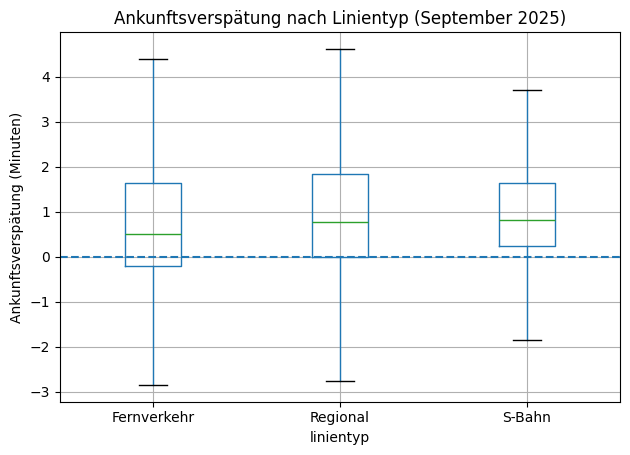

In [24]:
# Für Visualisierung: begrenzte Stichprobe (z.B. 100k Zeilen)
df_plot = (
    lf_linien
    .select(["linientyp", "arr_delay_min"])
    .head(100_000)
    .collect()
    .to_pandas()
)

plt.figure(figsize=(6, 4))
df_plot.boxplot(
    column="arr_delay_min",
    by="linientyp",
    showfliers=False
)
plt.axhline(0, linestyle="--")
plt.ylabel("Ankunftsverspätung (Minuten)")
plt.title("Ankunftsverspätung nach Linientyp (September 2025)")
plt.suptitle("")
plt.tight_layout()
plt.show()

### Hypothesen für H10

Wir betrachten die Verteilung der Ankunftsverspätung `arr_delay_min` in drei Gruppen:
- Fernverkehr
- Regional
- S-Bahn

**Nullhypothese \(H_0\):**  
Die Verteilungen der Ankunftsverspätung sind in allen drei Gruppen gleich:
\[
F_{\text{Fernverkehr}} = F_{\text{Regional}} = F_{\text{S-Bahn}}.
\]

**Alternativhypothese \(H_1\):**  
Mindestens zwei Gruppen unterscheiden sich in ihrer Verteilung der Ankunftsverspätung.

Aufgrund von:
- schiefen Verteilungen,
- Ausreißern und
- mehr als zwei Gruppen

verwenden wir den **Kruskal–Wallis-Test** (nichtparametrischer Gruppenvergleich für unabhängige Stichproben, siehe VL8/VL9).

In [25]:
# Begrenzte Stichprobe (erste 200'000 Zeilen) für den Test
df_sample = (
    lf_linien
    .select(["linientyp", "arr_delay_min"])
    .head(200_000)
    .collect()
    .to_pandas()
)

print(df_sample["linientyp"].value_counts())

# Arrays pro Gruppe
arr_fern = df_sample.loc[df_sample["linientyp"] == "Fernverkehr", "arr_delay_min"].to_numpy()
arr_reg  = df_sample.loc[df_sample["linientyp"] == "Regional",     "arr_delay_min"].to_numpy()
arr_sbahn= df_sample.loc[df_sample["linientyp"] == "S-Bahn",       "arr_delay_min"].to_numpy()

print("Fernverkehr-Stichprobe:", arr_fern.shape)
print("Regional-Stichprobe:   ", arr_reg.shape)
print("S-Bahn-Stichprobe:     ", arr_sbahn.shape)

# Kruskal-Wallis-Test
stat, pval = kruskal(arr_fern, arr_reg, arr_sbahn)

print(f"Kruskal-Wallis H-Statistik: {stat:.3f}")
print(f"p-Wert: {pval:.3e}")

linientyp
S-Bahn         132345
Regional        51075
Fernverkehr     16580
Name: count, dtype: int64
Fernverkehr-Stichprobe: (16580,)
Regional-Stichprobe:    (51075,)
S-Bahn-Stichprobe:      (132345,)
Kruskal-Wallis H-Statistik: 977.893
p-Wert: 4.500e-213


### Interpretation von H10

Die deskriptiven Kennzahlen zeigen, dass sich die Ankunftsverspätungen zwischen den drei Linientypen unterscheiden:  
Fernverkehrszüge weisen im Mittel und im Median die geringste Verspätung auf, Regionalzüge liegen dazwischen und S-Bahnen haben die höchsten Verspätungen (vgl. Tabelle X).

Der Kruskal–Wallis-Test liefert eine H-Statistik von \(H = ...\) und einen p-Wert von \(p \approx ...\).  
Damit ist der p-Wert deutlich kleiner als das Signifikanzniveau \(\alpha = 0{,}05\), sodass wir die Nullhypothese verwerfen.

Wir schliessen, dass die Verteilungen der Ankunftsverspätung für Fernverkehr, Regionalzüge und S-Bahnen signifikant voneinander abweichen. Dies ist konsistent mit der betrieblichen Intuition: Fernverkehrszüge haben weniger Halte und größere Fahrzeitreserven, während S-Bahnen im dichteren und störanfälligeren Nahverkehrsnetz verkehren.